In [1]:
from contextlib import suppress

import matplotlib.pyplot as plt
import pandas as pd
from faker import Faker
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from tqdm import tqdm

from string2image.generate import Generator

## Encoding characters as vectors
Some people will be familiar with the concept of encoding words as vectors using the Word2Vec algorithm.
Let's extend this concept to encode characters.

## Let's get some data to work with
Since the point of this technique is to do string comparisons that are domain specific, let's generate some data in the domain of personal information using the faker library.

In [2]:
fake = Faker()
data_sources = [
    fake.first_name,
    fake.last_name,
    fake.phone_number,
    fake.company,
    fake.street_address,
    fake.city,
    fake.postcode,
    fake.job,
    fake.ascii_email,
    fake.ssn,
]

### Next we will use a helper class to generate our data
The code below demonstrates the generator where we get the data to feed into our model

In [3]:
g = Generator(data_sources)
samples = g.random_data_gen(cnt=5)
for d in samples:
    print(d)

Data(label='postcode', value='43478')
Data(label='first_name', value='Erin')
Data(label='first_name', value='Katherine')
Data(label='last_name', value='Salazar')
Data(label='street_address', value='456 Gomez Place Suite 632')


#### Now we need to split the generated strings into characters and feed them into the model
Below are functions to train the model and visualize the embeddings (with reduced dimensions using the TSNE algorithm)

In [4]:
def create_model(batches=5):
    """
    code found here https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
    """
    train_words = g.random_data_gen(100_000)
    train_characters = map(lambda x: list(x.value), train_words)
    model = Word2Vec(train_characters, size=100, window=5, min_count=1,workers=4)

    for _ in tqdm(range(batches)):
        vocab_data = map(lambda x: list(x.value), g.random_data_gen(100_000))
        model.train(vocab_data, total_examples=1, epochs=1)
        
    return model

def plot_w2v(model):
    vocab = list(model.wv.vocab)
    X = model.wv[vocab]

    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)

    df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(df['x'], df['y'])
    for word, pos in df.iterrows():
        ax.annotate(word, pos)

### A couple of explainable observations
- Numeric characters get seperated from the others, along with symbols that go along with them ('-' for social)
- The 'x' is interesting since it goes with the numeric because it is associated with phone extensions
- Upper and lower case characters get differentiated
- The common vowels are clustered together

In general we can see how the subtle difference between character patterns is displayed

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.73s/it]


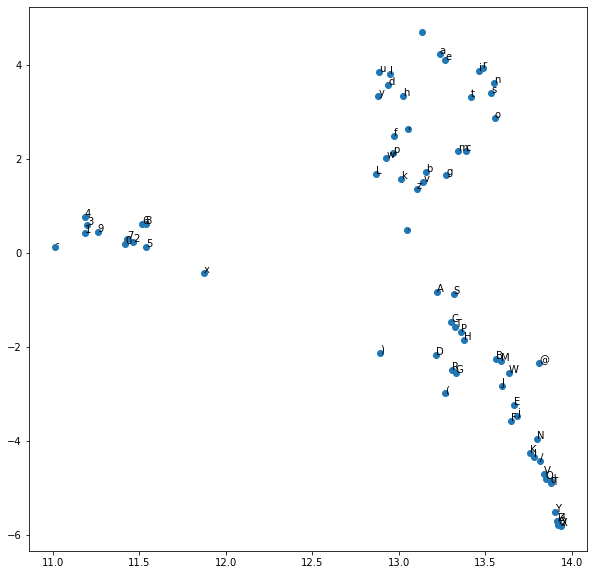

In [5]:
model = create_model(2)
plot_w2v(model)

### Training against more data
The differences generally get more pronounced when we have more data. The TSNE function does not yield the same results and our data is randomly generated so results may very.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.90s/it]


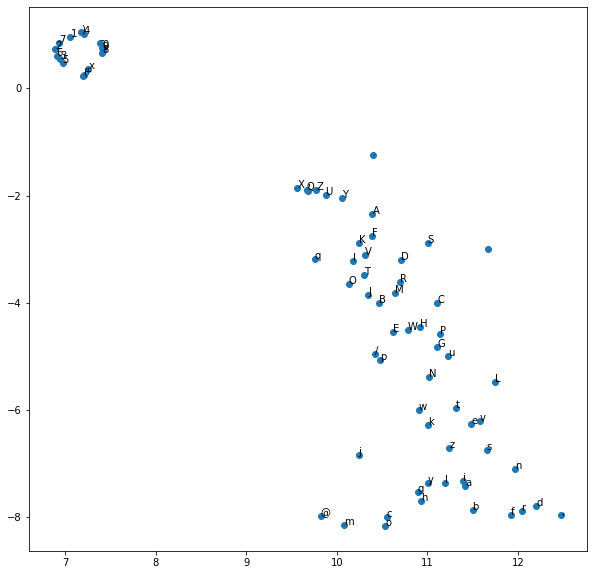

In [6]:
model = create_model(10)
plot_w2v(model)

#### We'll save the model for our next step, mapping each character in a string to its respective vector forming a image of sorts which can be used for a variety of computations.

In [7]:
model.save("word2vec.model")